# 0. Imports


In [93]:
import boto3
import pandas as pd
from sagemaker import get_execution_role

# 1. O Problema

## 1.1 O que é League of legends

**League of Legends** (abreviado como **LoL** e comumente referido como League) é um jogo
eletrônico do gênero multiplayer online battle arena (MOBA) desenvolvido e publicado pela Riot
Games.


No jogo, duas equipes de cinco jogadores batalham em um combate jogador contra jogador
(PvP), com cada equipe ocupando e defendendo sua metade do mapa. Cada um dos dez
jogadores controla um personagem, conhecido como "campeão", com habilidades únicas e
diferentes estilos de jogo. Durante uma partida, os campeões se tornam mais poderosos ao
coletarem pontos de experiência, ganharem ouro e comprarem itens a fim de derrotar a equipe
adversária. No modo principal, Summoner's Rift, o objetivo primário é avançar até a base
inimiga e destruir uma grande estrutura localizada em seu centro, sob o nome de "Nexus


https://www.youtube.com/watch?v=o-PZtGEHueY&ab_channel=CBLOL

## 1.2 Desafio

**Objetivo:**
Atualmente o Lol conta com 162 personagens disponiveis para escolha. Enquanto jogamos ou assistimos aos outros jogarem fica evidente que em alguns casos alguns personagens tem vantagens sobre os outros. Mas e se conseguissimos determinar qual a melhor escolha possível de forma a otimizar sua chace de vencer um jogo?

O objetivo neste trabalho é criar um modelo que indique os campeões que maximizem a chance de um time vencer após a definição das outras 9 escolhas.

O verdadeito game changer.

**Planejamento da solução**

- Analisar a viabilidade do modelo a partir de dados passados, ou seja com todas as informações que aocnteceram em uma partida
- Criar bases auxiliares com estetisticas dos personagens para que possomos criar um modelo a partir apenas dos personagens e alimentando com essas informações auxiliares (observação: Essa base deve conter apenas informações da base treino)
- Refazer o treinamento do modelo 1 com as novas indicações de estatisticas
- Modelo de regressão
- Métricas
    - F1-score




# 2. Fonte de dados

## 2.1 Extração API

O league of legends tem uma API própia para aqueles que desejam analisar os dados das partidas.

A API pdoe ser acessada pelo site https://developer.riotgames.com/

Neste trabalho foi necessário renovar a key toda a vez que era necessário uma extração de dados, porêm é possível solicitar uma key permanente, mas isso leva algum tempo, e não foi possível usa-la para este trabalho.

Por essse motivo o script de extração de dados foi executado na máquina local, extraindo dados das partidas dos 200 melhores jogadores da região do Brasil.

O script pode ser encontrado no githhub: **Colocar link aqui**

## 2.2 Carregando os dados

In [94]:
role = get_execution_role()
bucket='projeto-interdisciplinar'
data_key = 'partidas_detalhadas.xlsx'
data_location = 's3://{}/{}'.format(bucket, data_key)


In [3]:
base = pd.read_excel(data_location)

In [4]:
base.head()

,Partida,Tempo,Blue Team Victory,champion_id_Top_blue_side,champion_Top_blue_side,kill_Top_blue_side,death_Top_blue_side,assist_Top_blue_side,damage_per_minute_Top_blue_side,gold_per_minute_Top_blue_side,...,gold_per_minute_Adc_red_side,vision_per_minute_Adc_red_side,champion_id_Sup_red_side,champion_Sup_red_side,kill_Sup_red_side,death_Sup_red_side,assist_Sup_red_side,damage_per_minute_Sup_red_side,gold_per_minute_Sup_red_side,vision_per_minute_Sup_red_side
0,BR1_2607889462,32.950000,False,266,Aatrox,0,1,6,440.169051,390.094271,...,424.966404,1.226336,104.0,Graves,2.0,5.0,2.0,454.543289,375.587076,3.715915
1,BR1_2607868377,17.466667,False,84,Akali,6,3,0,640.653606,437.823471,...,612.495282,0.466930,412.0,Thresh,1.0,1.0,13.0,232.126795,306.794212,1.136832
2,BR1_2607843393,16.750000,False,164,Camille,2,4,4,452.764237,375.834466,...,623.614783,0.413094,25.0,Morgana,2.0,1.0,19.0,297.290379,373.592809,1.283953
3,BR1_2607796695,29.033333,True,164,Camille,6,4,3,688.090085,408.784779,...,463.537844,0.627343,497.0,Rakan,2.0,5.0,7.0,183.642915,247.911209,2.497650
4,BR1_2607756218,26.400000,True,157,Yasuo,7,0,10,601.782848,549.118970,...,331.528842,0.905511,24.0,Jax,2.0,4.0,0.0,385.149768,342.278600,1.018867


## 2.3 Estrutura dos dados

In [8]:
# como existem alguns dados nulos vamos remove-los para evitar ruidos já que são poucos. Isso não irá afetar nosso modelo final 
base.dropna(inplace=True)

In [9]:
base.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 35309 entries, 0 to 35324
Data columns (total 83 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   Partida                             35309 non-null  object 
 1   Tempo                               35309 non-null  float64
 2   Blue Team Victory                   35309 non-null  bool   
 3   champion_id_Top_blue_side           35309 non-null  int64  
 4   champion_Top_blue_side              35309 non-null  object 
 5   kill_Top_blue_side                  35309 non-null  int64  
 6   death_Top_blue_side                 35309 non-null  int64  
 7   assist_Top_blue_side                35309 non-null  int64  
 8   damage_per_minute_Top_blue_side     35309 non-null  float64
 9   gold_per_minute_Top_blue_side       35309 non-null  float64
 10  vision_per_minute_Top_blue_side     35309 non-null  float64
 11  champion_id_Jungle_blue_side        35309

Apesar da grande qauntidade de features, podemos resumir as 83 colunas em 11 tipos:

- Partida : Código da partida, irrelevante para análise e será retirado na hora da análise

- Tempo : Duração da partida                         

- Blue Team Victory : Indica a vitória ou derrota do time do lado azul

- champion_id_{**Posição**}_{**Time**}_side : Código do campeão escolhido pelo time na posição

- champion_{**Posição**}_{**Time**}_side: Nome do campeão escolhido pelo time na posição

- kill_{**Posição**}_{**Time**}_side: Abates do campeão escolhido pelo time na posição

- death_{**Posição**}_{**Time**}_side: Mortes do campeão escolhido pelo time na posição

- assist_{**Posição**}_{**Time**}_side: Assistências do campeão escolhido pelo time na posição

- damage_per_minute_{**Posição**}_{**Time**}_side: Dano por minuto do campeão escolhido pelo time na posição

- gold_per_minute_{**Posição**}_{**Time**}_side: Ouro ganho por minuto do campeão escolhido pelo time na posição

- vision_per_minute_{**Posição**}_{**Time**}_side: Ouro ganho por minuto do campeão escolhido pelo time na posição


## 2.4 Pré vizualização

In [95]:
posicao = [ "Top", "Jungle", "Mid", "Adc", "Sup"]
times = ["red", 'blue']

In [96]:
def display_analise(posicao, time):
    colunas = [ f'kill_{posicao}_{time}_side',
                f'death_{posicao}_{time}_side',
                f'assist_{posicao}_{time}_side',
                f'damage_per_minute_{posicao}_{time}_side',
                f'gold_per_minute_{posicao}_{time}_side',
                f'vision_per_minute_{posicao}_{time}_side']
    base_aux = base[colunas]
    base_aux.hist(bins=50, figsize=(20,15),color = time)
    display()

In [ ]:
for posi in posicao:
    for team in times:
        display_analise(posi, team)

## 2.5 Treino e teste

Checando por dados duplicados

In [13]:
base.duplicated().any()

True

In [14]:
len(base["Partida"].unique())

27477

In [15]:
base = base.drop_duplicates()

In [16]:
base.duplicated().any()

False

Ao analisar os dados podemos ver que a feature de visão por minuto apresenta um comportamento estranho próximo ao 0, por enquanto amnteremos esse dado assim, caso necessário após alguns testes podemos fazer algo a respeito disso.

**Amostras**

In [17]:
#Vamos remover a coluna que indica a partida
base.drop("Partida", axis = 1 , inplace = True)

In [18]:
base.reset_index(inplace= True, drop = True)

In [19]:
base["Blue Team Victory"] = base["Blue Team Victory"].astype(int)

In [20]:
#Removendo os códigos dos campeões
for posi in posicao:
    for team in times:
        base.drop(f"champion_id_{posi}_{team}_side", axis = 1 , inplace = True)

In [21]:
from sklearn.model_selection import train_test_split

base_train, base_test = train_test_split(base, test_size=0.2, stratify=base['Blue Team Victory'], random_state=42)

In [22]:

base_test.shape

(5496, 72)

In [23]:
base_train.shape

(21981, 72)

**Salvando as bases de treino e teste**

In [24]:
base_train.to_excel('s3://{}/{}'.format(bucket, "treino.xlsx"), index = False)

In [25]:
base_test.to_excel('s3://{}/{}'.format(bucket, "teste.xlsx"), index = False)

In [98]:
base_train = pd.read_excel('s3://{}/{}'.format(bucket, "treino.xlsx"))
base_test = pd.read_excel('s3://{}/{}'.format(bucket, "teste.xlsx"))

# 4. Explorando os dados

Correlação

In [97]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [99]:
base_train

,Tempo,Blue Team Victory,champion_Top_blue_side,kill_Top_blue_side,death_Top_blue_side,assist_Top_blue_side,damage_per_minute_Top_blue_side,gold_per_minute_Top_blue_side,vision_per_minute_Top_blue_side,champion_Jungle_blue_side,...,damage_per_minute_Adc_red_side,gold_per_minute_Adc_red_side,vision_per_minute_Adc_red_side,champion_Sup_red_side,kill_Sup_red_side,death_Sup_red_side,assist_Sup_red_side,damage_per_minute_Sup_red_side,gold_per_minute_Sup_red_side,vision_per_minute_Sup_red_side
0,29.266667,0,Volibear,6,10,10,784.722757,353.738982,0.617087,XinZhao,...,680.393435,453.649650,0.799200,Lux,2,4,13,500.806074,293.422910,1.680064
1,19.016667,1,Senna,11,5,37,1121.003060,827.065774,0.000000,Ashe,...,2461.205808,831.737737,0.000000,Khazix,14,7,12,1907.221571,772.750807,0.000000
2,38.150000,1,Yone,5,8,8,566.449448,398.102979,0.721335,Udyr,...,732.932191,389.362643,0.914738,Vayne,13,12,5,910.745552,471.965892,0.925017
3,27.316667,1,Viktor,10,5,7,989.688081,517.878877,1.430197,JarvanIV,...,612.118399,433.879960,0.645611,Pyke,2,9,11,295.550529,262.576136,2.606838
4,25.800000,0,Darius,3,6,2,339.453597,314.396763,0.391590,Karthus,...,471.973528,394.303704,0.881592,Ashe,3,4,14,525.044907,328.411679,2.913609
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21976,29.183333,0,Sylas,6,7,6,676.690278,406.522022,0.496031,Shaco,...,793.329477,576.973831,0.951117,Pyke,6,6,13,351.813995,327.086428,2.616595
21977,34.583333,1,Yone,7,8,9,1026.255766,451.109560,0.495546,Diana,...,642.594304,390.338694,0.787494,Rakan,0,6,22,273.812114,228.838065,2.353691
21978,26.233333,1,Akali,7,4,2,568.911238,432.219928,1.114022,Graves,...,602.512518,347.488617,0.160868,Lulu,2,1,9,186.354052,282.480099,1.757298
21979,20.266667,1,Sion,9,11,28,1135.540557,691.724941,0.000000,Ziggs,...,1918.608284,804.028187,0.000000,Soraka,2,6,41,611.293638,597.865287,0.000000


In [100]:
base_train["Blue Team Victory"].value_counts()

0    11333
1    10648
Name: Blue Team Victory, dtype: int64

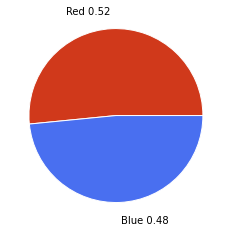

In [111]:

# create random data
names=f'Red {round(11333/(11333+10648),2)}', f'Blue {round(10648/(11333+10648),2)}'
values=[11333,10648]
colors = ['#D0391B', '#496FF0']

# Label distance: gives the space between labels and the center of the pie
plt.pie(values, labels=names, labeldistance=1.2, wedgeprops = { 'linewidth' : 1, 'edgecolor' : 'white' },colors=colors);
plt.show();

In [24]:
base_train.corr()["Blue Team Victory"].sort_values(ascending=False).to_frame().head(25)

,Blue Team Victory
Blue Team Victory,1.000000
death_Jungle_red_side,0.401020
assist_Sup_blue_side,0.391659
gold_per_minute_Jungle_blue_side,0.371917
death_Adc_red_side,0.356042
gold_per_minute_Adc_blue_side,0.350534
death_Sup_red_side,0.341440
death_Mid_red_side,0.338793
death_Top_red_side,0.330939
kill_Jungle_blue_side,0.320053


In [25]:
base_train.corr()["Blue Team Victory"].sort_values(ascending=True).to_frame().head(25)

,Blue Team Victory
death_Jungle_blue_side,-0.398823
assist_Sup_red_side,-0.385561
death_Adc_blue_side,-0.353507
death_Sup_blue_side,-0.340332
death_Mid_blue_side,-0.335401
gold_per_minute_Adc_red_side,-0.333843
death_Top_blue_side,-0.332824
gold_per_minute_Jungle_red_side,-0.332033
kill_Adc_red_side,-0.308952
kill_Jungle_red_side,-0.307718


Vamos criar um modelo de treinamento baseado primeiramente em todas as features e depois apenas com as 10 features mais relevantes para cada time.

In [9]:
relevantes_10 = [  'assist_Sup_blue_side',
                'gold_per_minute_Jungle_blue_side' ,
                'gold_per_minute_Adc_blue_side' ,
                'kill_Jungle_blue_side' ,
                'gold_per_minute_Mid_blue_side' ,
                'gold_per_minute_Top_blue_side' ,
                'kill_Adc_blue_side' ,
                'kill_Mid_blue_side' ,
                'assist_Jungle_blue_side' ,
                'assist_Adc_blue_side',
                'assist_Sup_red_side' ,
                'gold_per_minute_Adc_red_side' ,
                'gold_per_minute_Jungle_red_side' ,
                'kill_Adc_red_side' ,
                'kill_Jungle_red_side' ,
                'gold_per_minute_Mid_red_side' ,
                'kill_Mid_red_side' ,
                'gold_per_minute_Top_red_side' ,
                'assist_Jungle_red_side' ,
                'kill_Top_red_side' ]

# 5. Preparando os dados

## 5.1 Separando o target do resto

In [10]:
# separando o target do resto
base_train_pre = base_train.drop(columns=['Blue Team Victory'])
base_train_target = base_train['Blue Team Victory'].copy()

## 5.2 Separando Variáveis categóricas do resto

In [11]:
# categorical
categorical = []
for posi in posicao:
    for team in times:
        categorical.append(f"champion_{posi}_{team}_side")


# numerical atributes
num_attributes = base_train_pre.columns.drop(categorical)
#num_attributes = base_train_pre.columns.drop("Tempo")

# separating the features
base_train_pre_num = base_train_pre[num_attributes]
base_train_pre_cat = base_train_pre[categorical]

## 5.3 Pipeline

In [12]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import OneHotEncoder

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('robust_scaler', RobustScaler())
])


cat_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),  # as the categories are numbers, we can use the SimpleImputer
    ('one-hot-encoding', OneHotEncoder(handle_unknown='ignore'))
])


# (name, transformer, columns)
preprocessed_pipeline = ColumnTransformer([
    ('numerical', num_pipeline, num_attributes),
    ('categorical', cat_pipeline, categorical)
])

## 5.4 Pipeline secundaria

In [13]:
# categorical
categorical_2 = []
for posi in posicao:
    for team in times:
        categorical_2.append(f"champion_{posi}_{team}_side")

# separating the features
base_train_pre_num = base_train_pre[relevantes_10]
base_train_pre_cat = base_train_pre[categorical_2]



num_pipeline_2 = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('robust_scaler', RobustScaler())
])


cat_pipeline_2 = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),  # as the categories are numbers, we can use the SimpleImputer
    ('one-hot-encoding', OneHotEncoder(handle_unknown='ignore'))
])


# (name, transformer, columns)
preprocessed_pipeline_nova = ColumnTransformer([
    ('numerical', num_pipeline_2, relevantes_10),
    ('categorical', cat_pipeline_2, categorical_2)
])

# 6. Seleção de modelos inicial

In [14]:
X_train = preprocessed_pipeline.fit_transform(base_train_pre)
X_train.shape

(21981, 1680)

In [15]:
X_train_compress = preprocessed_pipeline_nova.fit_transform(base_train_pre[relevantes_10+categorical_2])

In [16]:
y_train = base_train_target

In [14]:
# printing function
import statistics
def display_scores(scores):
    print("Scores:", scores)
    try:
        print("\nMean:", scores.mean())
        print("Standard deviation:", scores.std())
    except:
        print("\nMean:", statistics.mean(scores))
        print("Standard deviation:", statistics.stdev(scores))

## 6.1 Modelos classificadores

In [15]:
import warnings
warnings.filterwarnings("ignore")

In [16]:
from sklearn.model_selection import cross_val_score , cross_val_predict
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, LinearSVC, NuSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score
from sklearn.model_selection import KFold

In [17]:
def teste_modelos( modelo , treino_full , treino_relevantes, treino_target):
    print("---------- Treino Full -----------")
    avaliar_full = cross_val_score(modelo, treino_full, treino_target, scoring="f1", cv=10)
    display_scores(avaliar_full)
    print("---------- Treino relevantes -----------")
    avaliar_compacto = cross_val_score(modelo, treino_relevantes, treino_target, scoring="f1", cv=10)
    display_scores(avaliar_compacto)

### 6.1.1 KNN

In [45]:
teste_modelos( KNeighborsClassifier() , X_train , X_train_compress, y_train)

---------- Treino Full -----------
Scores: [0.92769953 0.93040991 0.92850511 0.93432007 0.91856061 0.92565056
 0.92336802 0.92307692 0.93080569 0.91825095 0.91115312 0.91346154
 0.93142857 0.93457944 0.92775665 0.9273743  0.92205323 0.91753555
 0.93506494 0.92509363]

Mean: 0.9253074170816186
Standard deviation: 0.006701620729891724
---------- Treino relevantes -----------
Scores: [0.92465116 0.9280303  0.90926099 0.93023256 0.93245779 0.92063492
 0.92526017 0.91557223 0.92107707 0.91690009 0.91369606 0.9111319
 0.91471415 0.93572779 0.92       0.92048644 0.91627469 0.92469018
 0.93106704 0.92931197]

Mean: 0.9220588754585435
Standard deviation: 0.007328048167011828


### 6.1.2 SVC

In [46]:
teste_modelos( SVC() , X_train , X_train_compress, y_train)

---------- Treino Full -----------
Scores: [0.96545285 0.97282099 0.97191011 0.97378277 0.96707432 0.97089202
 0.96986817 0.96635514 0.97744361 0.95692884 0.96545285 0.95798319
 0.95970009 0.96525822 0.97276995 0.96089385 0.96525822 0.96310312
 0.96913003 0.96157451]

Mean: 0.9666826427954474
Standard deviation: 0.0054838860441932735
---------- Treino relevantes -----------
Scores: [0.96992481 0.97110904 0.96060038 0.9637883  0.97185741 0.96545285
 0.96030246 0.95732839 0.95586854 0.9544186  0.95497186 0.94924812
 0.95586854 0.96240602 0.96135721 0.95530726 0.95813953 0.96091516
 0.96435272 0.95692884]

Mean: 0.9605073020579141
Standard deviation: 0.005820406744395805


### 6.1.3 DecisionTreeClassifier

In [21]:
teste_modelos( DecisionTreeClassifier() , X_train , X_train_compress, y_train)

---------- Treino Full -----------
Scores: [0.86228112 0.86614173 0.86903648 0.86276347 0.86344439 0.8489757
 0.84713677 0.86087768 0.85700802 0.86647993]

Mean: 0.8604145297659113
Standard deviation: 0.006935950324615867
---------- Treino relevantes -----------
Scores: [0.87388654 0.86842105 0.86750349 0.87494189 0.8682243  0.85256712
 0.8587624  0.86635071 0.86622391 0.86283816]

Mean: 0.8659719570671539
Standard deviation: 0.006310404079709598


### 6.1.4 RandomForestClassifier

In [22]:
teste_modelos( RandomForestClassifier() , X_train , X_train_compress, y_train)

---------- Treino Full -----------
Scores: [0.94607379 0.94057089 0.94412879 0.9402277  0.93655303 0.93604927
 0.94418165 0.93879473 0.9379771  0.95026054]

Mean: 0.9414817487813485
Standard deviation: 0.004337734344776206
---------- Treino relevantes -----------
Scores: [0.94460094 0.93383388 0.93358279 0.9275911  0.92883895 0.93194707
 0.93434105 0.93126177 0.93029872 0.93446488]

Mean: 0.9330761145107932
Standard deviation: 0.004444104356167958


### 6.1.5 AdaBoostClassifier

In [23]:
teste_modelos( AdaBoostClassifier() , X_train , X_train_compress, y_train)

---------- Treino Full -----------
Scores: [0.94870588 0.9309057  0.94470478 0.94128699 0.93005671 0.93206651
 0.93829487 0.93426573 0.93962264 0.93464974]

Mean: 0.9374559548957251
Standard deviation: 0.005864594122625226
---------- Treino relevantes -----------
Scores: [0.94007491 0.93208431 0.93314633 0.93056212 0.92602996 0.91975598
 0.93527205 0.92329545 0.92772792 0.92531705]

Mean: 0.9293266074112239
Standard deviation: 0.005762531758220728


### 6.1.6 GradientBoostingClassifier

In [24]:
teste_modelos( GradientBoostingClassifier() , X_train , X_train_compress, y_train)

---------- Treino Full -----------
Scores: [0.96094118 0.95393206 0.95725693 0.95287465 0.94894614 0.95040151
 0.95291902 0.95023474 0.95130024 0.94889827]

Mean: 0.952770472425424
Standard deviation: 0.0036344729277052795
---------- Treino relevantes -----------
Scores: [0.95175644 0.94845361 0.94387278 0.94642857 0.93408135 0.93752936
 0.9462771  0.94211765 0.9465721  0.94657919]

Mean: 0.9443668143341302
Standard deviation: 0.004968006740419588


### 6.1.7 Regressor logistico

In [26]:
teste_modelos( LogisticRegression() , X_train , X_train_compress, y_train)

---------- Treino Full -----------
Scores: [0.97510568 0.97551789 0.97886332 0.97411765 0.96904315 0.96752941
 0.97218293 0.96850024 0.96847059 0.97040864]

Mean: 0.9719739499538264
Standard deviation: 0.003600050975727407
---------- Treino relevantes -----------
Scores: [0.96567936 0.96123307 0.96946923 0.96411709 0.95765472 0.95028143
 0.96244131 0.96219282 0.95750708 0.96275605]

Mean: 0.9613332169741347
Standard deviation: 0.004971395114296107


## 6.3 Modelos selecionados

A Partir dos resultados tanto no dataset completo quanto no reduzido vamos seguir com os classificadores com maior score inicial
Dos modelos restantes vamos escolher os que obtiveram melhores médias de score:
- **LogisticRegression**
- **SVC**
- **GradientBoostingClassifier**

# 7. Otimização de parâmetros 

Com esses três modelos pré selecionados vamos seguir tentando melhorar ainda mais o resultado deles.
criaremos uma função com os seguintes passos:
- Separar treino em um novo treino/teste
- Cirar a trasnformação do treino
- Aplicar no teste
- Testar modelo
- Revisar threshold do melhor parâmetro
- Modelo final

Neste caso usaremos apenas a base reduzida, apenas com as features mais importantes

## 7.1 Função

**Tentar criar a tabela auxiliarpensndo em quem é o adversário**

In [18]:
from sklearn.model_selection import GridSearchCV, train_test_split, StratifiedKFold

In [19]:
base_train = pd.read_excel('s3://{}/{}'.format(bucket, "treino.xlsx"))

In [20]:
base_train_final, base_test_final = train_test_split(base_train, test_size=0.2, stratify=base_train['Blue Team Victory'], random_state=42)


In [21]:
X_train = preprocessed_pipeline_nova.fit_transform(base_train_final[relevantes_10+categorical_2])
y_train =  base_train_final['Blue Team Victory'].copy()
X_test = preprocessed_pipeline_nova.transform(base_test_final[relevantes_10+categorical_2])
y_test =  base_test_final['Blue Team Victory'].copy()

In [25]:
def otimiza_modelos(modelo , parametros):
    
    
    skf = StratifiedKFold(n_splits=5)
    grid_search = GridSearchCV(modelo, parametros, scoring="f1",
                           cv=skf, return_train_score=True, n_jobs=-1)
    grid_search.fit(X_train, y_train.values)

    # make the predictions
    y_pred = grid_search.predict(X_test)
    print(f1_score(y_test, y_pred, zero_division=1))
    print(grid_search.best_params_)
    


## 7.2 Logistic Regression

In [60]:
# Base Line
clf = LogisticRegression()
clf.fit(X_train,y_train)
preds = clf.predict(X_test)
print(f1_score(y_test, preds, zero_division=1))

0.9644789461303223


In [44]:
pars = {
    
    'penalty' : ['l1', 'l2', 'elasticnet', 'none'],
    'solver' : ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
    'multi_class': ['auto'],
    'max_iter': [500]
}

In [45]:
otimiza_modelos(LogisticRegression() , pars)

0.9644789461303223
{'max_iter': 500, 'multi_class': 'auto', 'penalty': 'l2', 'solver': 'liblinear'}


## 7.3 SVC

In [23]:
# Base Line
clf = SVC()
clf.fit(X_train,y_train)
preds = clf.predict(X_test)
print(f1_score(y_test, preds, zero_division=1))

0.9653558052434457


In [28]:
pars_svc ={ "C" : [1,2],
           'degree' : [1,3],
          'decision_function_shape' : ['ovo', 'ovr']
}

In [29]:
otimiza_modelos(SVC() , pars_svc)

0.9669402110199297
{'C': 2, 'decision_function_shape': 'ovo', 'degree': 1}


## 7.4 gradientebooster

In [30]:
# Base Line
clf = GradientBoostingClassifier()
clf.fit(X_train,y_train)
preds = clf.predict(X_test)
print(f1_score(y_test, preds, zero_division=1))

0.9451893672077158


In [31]:
pars_gradient ={ 'loss' : ['log_loss', 'exponential'] ,
               'learning_rate' : [ 0.1 , 0.5 ],
               'n_estimators': [ 100 , 300 ],
               'criterion' :['friedman_mse', 'squared_error', 'mse'],
               'max_depth' : [3 , 5]}

In [32]:
otimiza_modelos(GradientBoostingClassifier() , pars_gradient)

/home/ec2-user/anaconda3/envs/python3/lib/python3.8/site-packages/sklearn/ensemble/_gb.py:471: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warnings.warn(
/home/ec2-user/anaconda3/envs/python3/lib/python3.8/site-packages/sklearn/ensemble/_gb.py:471: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warnings.warn(
/home/ec2-user/anaconda3/envs/python3/lib/python3.8/site-packages/sklearn/ensemble/_gb.py:471: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warnings.warn(
/home/ec2-user/anaconda3/envs/python3/lib/python3.8/site-packages/sklearn/ensemble/_gb.py:471: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalen

0.9552520018841262
{'criterion': 'friedman_mse', 'learning_rate': 0.5, 'loss': 'exponential', 'max_depth': 3, 'n_estimators': 300}


/home/ec2-user/anaconda3/envs/python3/lib/python3.8/site-packages/sklearn/tree/_classes.py:359: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warnings.warn(
/home/ec2-user/anaconda3/envs/python3/lib/python3.8/site-packages/sklearn/tree/_classes.py:359: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warnings.warn(
/home/ec2-user/anaconda3/envs/python3/lib/python3.8/site-packages/sklearn/tree/_classes.py:359: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warnings.warn(
/home/ec2-user/anaconda3/envs/python3/lib/python3.8/site-packages/sklearn/tree/_classes.py:359: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equiv

0.9552520018841262
{'criterion': 'friedman_mse', 'learning_rate': 0.5, 'loss': 'exponential', 'max_depth': 3, 'n_estimators': 300}

# 8. Otimização de threshold
Apesar da base ser bem balanceada testaremos essa variação apenas por fins didáticos

In [62]:
teste = [ 0.4 , 0.42 , 0.44 , 0.46 , 0.48, 0.5 , 0.52 , 0.54 , 0.56 , 0.58, 0.6 ]
def otimiza_thresold(modelo):
    global predict_mine,preds
    aux = []
    modelo.fit(X_train,y_train)
    preds = modelo.predict_proba(X_test)
    new_preds = []
    for i in range(len(preds)):
        new_preds.append(list(list(preds)[i])[1])
    preds = modelo.predict(X_test)

    for i in teste: 
        dict_aux = {}
        predict_mine = [1 if num>i else 0 for num in new_preds]
        #predict_mine = np.where(preds > i, 1, 0)
        dict_aux["TH"] = i
        dict_aux["F1"] = f1_score(y_test, predict_mine, zero_division=1)
        aux.append(dict_aux)
    print(pd.DataFrame(aux).sort_values(by = "F1" , ascending= False).head())
        

## 8.1 Regressão Logistica

In [63]:
modelo = LogisticRegression()
otimiza_thresold(modelo)

     TH        F1
2  0.44  0.965081
4  0.48  0.964496
5  0.50  0.964479
0  0.40  0.964244
1  0.42  0.964194


## 8.2 SVC

In [66]:
modelo = SVC(C= 2, decision_function_shape = 'ovo', degree = 1,probability=True)
otimiza_thresold(modelo)

      TH        F1
2   0.44  0.967125
3   0.46  0.967064
4   0.48  0.967002
10  0.60  0.966825
8   0.56  0.966690


## 8.3 GradientBoostingClassifier

In [67]:
modelo = GradientBoostingClassifier(criterion= 'friedman_mse', learning_rate =  0.5, loss= 'exponential', max_depth= 3, n_estimators = 300)
otimiza_thresold(modelo)


      TH        F1
1   0.42  0.957681
0   0.40  0.957477
2   0.44  0.957377
10  0.60  0.956852
3   0.46  0.956808


# 9. Modelo Final

Apesar da busca para a otimização dos hyperparametros, nenhum dos usados foi efetivo, ou seja iremos utilizar o modelo padrão.

In [71]:
# leitura das bases separadas inicialmente
base_train = pd.read_excel('s3://{}/{}'.format(bucket, "treino.xlsx"))
base_test = pd.read_excel('s3://{}/{}'.format(bucket, "teste.xlsx"))

In [72]:
X_train = preprocessed_pipeline_nova.fit_transform(base_train[relevantes_10+categorical_2])
y_train =  base_train['Blue Team Victory'].copy()
X_test = preprocessed_pipeline_nova.transform(base_test[relevantes_10+categorical_2])
y_test =  base_test['Blue Team Victory'].copy()

## 9.1 Treino dos modelos

In [85]:
modelo_1 = LogisticRegression()
modelo_1.fit(X_train,y_train)
preds_1 = modelo_1.predict_proba(X_test)
new_preds = []
for i in range(len(preds_1)):
    new_preds.append(list(list(preds_1)[i])[1])
predict_mine_1 = [1 if num > 0.44 else 0 for num in new_preds]


In [84]:
modelo_2 = SVC(C= 2, decision_function_shape = 'ovo', degree = 1,probability=True)
modelo_2.fit(X_train,y_train)
preds_2 = modelo_2.predict_proba(X_test)
new_preds = []
for i in range(len(preds_2)):
    new_preds.append(list(list(preds_2)[i])[1])
predict_mine_2 = [1 if num > 0.44 else 0 for num in new_preds]

In [86]:
modelo_3 = GradientBoostingClassifier(criterion= 'friedman_mse', learning_rate =  0.5, loss= 'exponential', max_depth= 3, n_estimators = 300)
modelo_3.fit(X_train,y_train)
preds_3 = modelo_3.predict_proba(X_test)
new_preds = []
for i in range(len(preds_3)):
    new_preds.append(list(list(preds_3)[i])[1])
predict_mine_3 = [1 if num > 0.42 else 0 for num in new_preds]

## 9.2 Majority voting

In [87]:
resultado_final = [ ]
for i in range (len(predict_mine_1)):
    if predict_mine_3[i]+predict_mine_2[i]+predict_mine_1[i]>=2:
        resultado_final.append(1)
    else:
        resultado_final.append(0)

## 9.3 Resultados

## 9.3.1 Majority voting

-------------F1 Score---------------
0.9665982459414071
------------------------------------


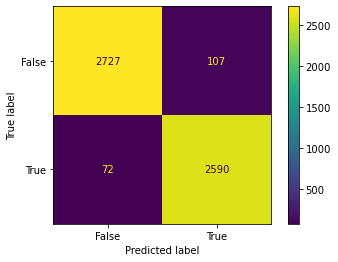

In [88]:
import matplotlib.pyplot as plt
import numpy
from sklearn import metrics

actual = y_test
predicted = resultado_final
print("-------------F1 Score---------------")
print(f1_score(y_test, predicted, zero_division=1))
print("------------------------------------")
confusion_matrix = metrics.confusion_matrix(actual, predicted)

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])

cm_display.plot()
plt.show()

## 9.3.2 Logistic

-------------F1 Score---------------
0.9613011777902412
------------------------------------


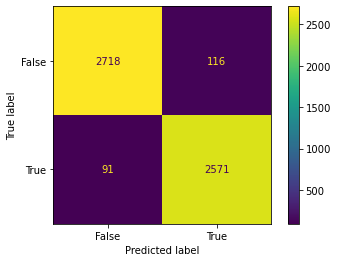

In [89]:
predicted = predict_mine_1
print("-------------F1 Score---------------")
print(f1_score(y_test, predicted, zero_division=1))
print("------------------------------------")
confusion_matrix = metrics.confusion_matrix(actual, predicted)

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])

cm_display.plot()
plt.show()


## 9.3.3 svc

-------------F1 Score---------------
0.9654915127774669
------------------------------------


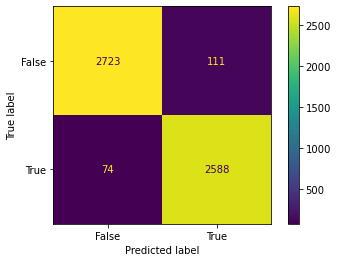

In [90]:
predicted = predict_mine_2
print("-------------F1 Score---------------")
print(f1_score(y_test, predicted, zero_division=1))
print("------------------------------------")
confusion_matrix = metrics.confusion_matrix(actual, predicted)

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])

cm_display.plot()
plt.show()

## 9.3.4 gradient

-------------F1 Score---------------
0.9563595673256248
------------------------------------


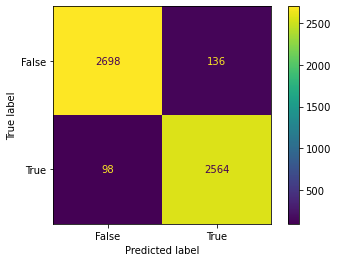

In [91]:
predicted = predict_mine_3
print("-------------F1 Score---------------")
print(f1_score(y_test, predicted, zero_division=1))
print("------------------------------------")
confusion_matrix = metrics.confusion_matrix(actual, predicted)

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])

cm_display.plot()
plt.show()

# 10. Sugestão de escolhas

Pensando que a sugestão ocorre antes de sabermos o desempenho de cada jogador em um jogo, vamos precisar estabelecer métricas médias de desempenho a partir de dados que já foram usados.
Portanto criaremos uma tabela auxiliar com métricas de partidas passadas baseadas no campeao

## 10.1 Base auxiliar

In [112]:
def analise_auxiliar(posicao, time, campeao,base_train_final):
    dicionario = {}
    dicionario["campeao"] = campeao
    dicionario["time"] = time
    dicionario["posicao"] = posicao
    dicionario["kill"] = statistics.mean(base_train_final.loc[base_train_final[f'champion_{posi}_{team}_side'] == campeao,   f'kill_{posicao}_{time}_side'])
    dicionario["death"] = statistics.mean(base_train_final.loc[base_train_final[f'champion_{posi}_{team}_side'] == campeao,   f'death_{posicao}_{time}_side'])
    dicionario["assist"] = statistics.mean(base_train_final.loc[base_train_final[f'champion_{posi}_{team}_side'] == campeao,   f'assist_{posicao}_{time}_side'])
    dicionario["dano"] = statistics.mean(base_train_final.loc[base_train_final[f'champion_{posi}_{team}_side'] == campeao,   f'damage_per_minute_{posicao}_{time}_side'])
    dicionario["ouro"] = statistics.mean(base_train_final.loc[base_train_final[f'champion_{posi}_{team}_side'] == campeao,   f'gold_per_minute_{posicao}_{time}_side'])
    dicionario["visao"] = statistics.mean(base_train_final.loc[base_train_final[f'champion_{posi}_{team}_side'] == campeao,   f'vision_per_minute_{posicao}_{time}_side'])
    return dicionario

In [113]:
# Criação da nova base auxiliar 

lista_auxiliar = []
for posi in posicao:
    for team in times:
        for campeao in base_train_pre[f'champion_{posi}_{team}_side'].unique():
            lista_auxiliar.append(analise_auxiliar(posi, team, campeao,base_train_pre))
            

aux_exploratorio = pd.DataFrame(lista_auxiliar)

## 10.2 Sugestão

In [200]:
# input das escolhas já definidas
escolhas = {
            'champion_Top_red_side' :  "Tryndamere",
            'champion_Top_blue_side' :  "Illaoi",
            'champion_Jungle_red_side' :  "Amumu",
            'champion_Jungle_blue_side' :  "Rammus",
            'champion_Mid_red_side' :  None,
            'champion_Mid_blue_side' : "Lux" ,
            'champion_Adc_red_side' :  "Xayah",
            'champion_Adc_blue_side' : "Vayne" ,
            'champion_Sup_red_side' :  "Singed",
            'champion_Sup_blue_side' : "Renata" 
}

In [181]:
def busca_aux(time, posicao, campeao, feature):
    return aux_exploratorio.loc[(aux_exploratorio["campeao"] == campeao) & (aux_exploratorio["time"] == time) & (aux_exploratorio["posicao"] == posicao),feature].values[0]

In [182]:
df = pd.DataFrame([escolhas])

In [183]:
ja_escolhidos = []
for posi in posicao:
    for team in times:
        if df.loc[0, f'champion_{posi}_{team}_side'] != None:
            df[ f'kill_{posi}_{team}_side'] = df.apply(lambda x:busca_aux(team,posi,x[f'champion_{posi}_{team}_side'],"kill"),axis = 1)
            df[f'death_{posi}_{team}_side'] = df.apply(lambda x:busca_aux(team,posi,x[f'champion_{posi}_{team}_side'],"death"),axis = 1)
            df[f'assist_{posi}_{team}_side'] = df.apply(lambda x:busca_aux(team,posi,x[f'champion_{posi}_{team}_side'],"assist"),axis = 1)
            df[f'damage_per_minute_{posi}_{team}_side'] = df.apply(lambda x:busca_aux(team,posi,x[f'champion_{posi}_{team}_side'],"dano"),axis = 1)
            df[f'gold_per_minute_{posi}_{team}_side'] = df.apply(lambda x:busca_aux(team,posi,x[f'champion_{posi}_{team}_side'],"ouro"),axis = 1)
            df[f'vision_per_minute_{posi}_{team}_side'] = df.apply(lambda x:busca_aux(team,posi,x[f'champion_{posi}_{team}_side'],"visao"),axis = 1)
            ja_escolhidos.append(df.loc[0, f'champion_{posi}_{team}_side'])
        else:
            aux =  {'posicao' : posi , 'time' : team}

In [184]:
campeoes_restantes = [x for x in list(aux_exploratorio['campeao'].unique()) if x not in ja_escolhidos]


In [185]:
lista_previsao = []
for campeao in campeoes_restantes:
    resposta = { }
    copia_df = df.copy()
    copia_df.loc[0,f'champion_{aux["posicao"]}_{aux["time"]}_side'] = campeao
    resposta["campeao"] = campeao
    copia_df[ f'kill_{aux["posicao"]}_{aux["time"]}_side'] = copia_df.apply(lambda x:busca_aux(team,posi,campeao,"kill"),axis = 1)
    copia_df[f'death_{aux["posicao"]}_{aux["time"]}_side'] = copia_df.apply(lambda x:busca_aux(team,posi,campeao,"death"),axis = 1)
    copia_df[f'assist_{aux["posicao"]}_{aux["time"]}_side'] = copia_df.apply(lambda x:busca_aux(team,posi,campeao,"assist"),axis = 1)
    copia_df[f'damage_per_minute_{aux["posicao"]}_{aux["time"]}_side'] = copia_df.apply(lambda x:busca_aux(team,posi,campeao,"dano"),axis = 1)
    copia_df[f'gold_per_minute_{aux["posicao"]}_{aux["time"]}_side'] = copia_df.apply(lambda x:busca_aux(team,posi,campeao,"ouro"),axis = 1)
    copia_df[f'vision_per_minute_{aux["posicao"]}_{aux["time"]}_side'] = copia_df.apply(lambda x:busca_aux(team,posi,campeao,"visao"),axis = 1)
    
    
    if aux["time"] == "blue":
        number = 1
    else:
        number =0
    X_test = preprocessed_pipeline_nova.transform(copia_df[relevantes_10+categorical_2])
    
    preds_1 = modelo_1.predict_proba(X_test)
    new_preds = []
    for i in range(len(preds_1)):
        new_preds.append(list(list(preds_1)[i])[number])
    predict_mine_1 = [num if num > 0.44 else num for num in new_preds]
    
    
    preds_2 = modelo_2.predict_proba(X_test)
    new_preds = []
    for i in range(len(preds_2)):
        new_preds.append(list(list(preds_2)[i])[number])
    predict_mine_2 = [num if num > 0.44 else num for num in new_preds]
    
    
    preds_3 = modelo_3.predict_proba(X_test)
    new_preds = []
    for i in range(len(preds_3)):
        new_preds.append(list(list(preds_3)[i])[number])
    predict_mine_3 = [num if num > 0.42 else num for num in new_preds]
    
    resposta["model 1"] = predict_mine_1[0]
    resposta["model 2"] = predict_mine_2[0]
    resposta["model 3"] = predict_mine_3[0]
    resposta["media"] = (predict_mine_1[0] + predict_mine_2[0] + predict_mine_3[0])/3
    
    lista_previsao.append(resposta)

In [186]:
pd.DataFrame(lista_previsao).sort_values(by = "media" , ascending = False).head()

,campeao,model 1,model 2,model 3,media
74,Urgot,0.999997,0.999993,0.999999,0.999996
39,Jayce,0.999991,0.999988,0.999999,0.999993
115,KogMaw,0.999990,0.999987,0.999998,0.999992
47,Nilah,0.999989,0.999987,0.999998,0.999991
0,Rengar,0.999987,0.999986,0.999997,0.999990


# 11. Conlusões

O Modelo apesar de ser muito poderoso na previsão passa a não ter muita utilidade já que ele é muito bom com dados do passado.
Quando passamos para o modelo de sugestão, apesar de não termos métricas para medir a efetividade dele, é possível notar que as recomendações não fazem tanto sentido assim, portanto é palusivel supoer que a análise feita a partir das médais dos dados antigos não é boa, e seria encessário alguma alternativa para um modelo de recomendação decente

Quanto a próximos passos, acredito que seja possível melhorar aina mais este modelo principalmente com hyperparametros e utilizando mais modelos para o voto majoritário.

Outro ponto de melhoria seria rodar os modelos em paralelo a fim de